# Importing libraries

In [496]:
from collections import defaultdict
from typing import Optional

import numpy as np
import pandas as pd
import scipy.io
import seaborn as sns
from matplotlib import pyplot as plt
from pandas import DataFrame
from pydantic import BaseModel
from sklearn.ensemble import IsolationForest
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.neighbors import LocalOutlierFactor
from sklearn.model_selection import train_test_split


# Configuring pandas

In [497]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1200)
pd.set_option('display.colheader_justify', 'center')
pd.set_option('display.precision', 3)

# Loading datasets

In [498]:
from pydantic import Field, validator


class DF(DataFrame):
    @classmethod
    def __get_validators__(cls):
        yield cls.validate

    @classmethod
    def validate(cls, v):
        if not isinstance(v, DataFrame):
            raise ValueError('Expected DataFrame from pandas')
        return v

    def __repr__(self):
        return f'DataFrame({super().__repr__()})'

    def __str__(self):
        return f'DataFrame({super().__str__()})'


class Dataset(BaseModel):
    name: str
    x: DF = Field(DF, repr=False)
    y: DF = Field(DF, repr=False)

    x_train: DF = None
    y_train: DF = None
    x_test: DF = None
    y_test: DF = None

    y_pred: Optional[DF] = Field(DF, repr=False)
    scores_pred: Optional[DF] = Field(DF, repr=False)

    def split_data(self):
        self.x_train, self.x_test, self.y_train, self.y_test = train_test_split(self.x, self.y, test_size=0.2)
        return self

class Datasets(BaseModel):
    datasets: dict[str, Dataset]

In [499]:
def dataset_loader(dataset_names: tuple, verbose: bool = False):
    datasets = defaultdict(Dataset)
    for dataset_name in dataset_names:
        raw_data = scipy.io.loadmat(f'../datasets/{dataset_name}.mat')

        x = np.array(raw_data.get('X'))
        y = np.array(raw_data.get('y')).ravel().astype(dtype=np.uint8)

        # TODO: split into train and test dataset, use splitted datasets in experiments
        dataset = Dataset(
            name=dataset_name,
            x=x,
            y=y,
        )
        if verbose:
            print(
                f"Name: {dataset.name}\n"
                f"X: {dataset.x.shape}\n"
                f"Y: {dataset.y.shape}\n"
            )
            # print(dataset.x.head(), end="\n\n")
            # print(dataset.y.head())

        datasets[dataset_name] = dataset
    return Datasets(datasets=datasets)

In [500]:
datasets = dataset_loader(dataset_names=('pima', 'pendigits', 'cardio'), verbose=True)

ValidationError: 2 validation errors for Dataset
x
  Expected DataFrame from pandas (type=value_error)
y
  Expected DataFrame from pandas (type=value_error)

# Statistics

In [ ]:
def correlation_map(dataset: Dataset, figsize=(20, 20)):
    # get correlations of each features in dataset
    corrmat = dataset.x.corr()
    top_corr_features = corrmat.index
    plt.figure(figsize=figsize)
    #plot heat map
    g = sns.heatmap(dataset.x[top_corr_features].corr(), annot=True, cmap="RdYlGn")

In [ ]:
def accuracy_report(dataset: Dataset):
    n_errors = int((pima.y_pred != pima.y).sum().iloc[0])
    print(f"Number of errors : {n_errors}")
    print("Accuracy Score :", accuracy_score(dataset.y, dataset.y_pred))
    print("Classification Report :\n", classification_report(dataset.y, dataset.y_pred))

In [ ]:
def conf_matrix_plot(dataset: Dataset):
    cm = confusion_matrix(dataset.y, dataset.y_pred)
    disp = ConfusionMatrixDisplay(cm)
    disp.plot()
    plt.show()

In [515]:
def roc_curve_plot(datasets: Datasets):
    for name, dataset in datasets.datasets.items():
        fpr, tpr, thresh = roc_curve(dataset.y, dataset.scores_pred)
        auc = roc_auc_score(dataset.y, dataset.scores_pred)
        plt.plot(tpr, fpr, label=f"Dataset: {dataset.name}, auc={round(1 - auc, 3)}")
    plt.plot([0, 1], [0, 1], "k--")
    plt.legend(loc=0)
    plt.show()

# PIMA dataset

In [ ]:
pima = datasets.datasets["pima"]
pima.x.head()

In [ ]:
pima.x.describe()

In [ ]:
pima.x.hist(figsize=(28, 4), bins=25, xlabelsize=8, ylabelsize=8, xrot=45, layout=(1, 8), sharey=True, zorder=2,
            rwidth=0.9)

In [ ]:
pima.y.describe()

In [ ]:
pima.y.value_counts()

In [ ]:
correlation_map(pima, figsize=(6, 6))

# Pendigits dataset

In [ ]:
pendigits = datasets.datasets["pendigits"]
pendigits.x.head()

In [ ]:
pendigits.x.describe()

In [ ]:
pendigits.x.hist(figsize=(28, 8), bins=25, xlabelsize=8, ylabelsize=8, xrot=45, layout=(2, 8), sharey=True, zorder=2,
                 rwidth=0.9)

In [ ]:
pendigits.y.describe()

In [ ]:
pendigits.y.value_counts()

In [ ]:
correlation_map(pendigits, figsize=(9, 9))

# Cardio dataset

In [ ]:
cardio = datasets.datasets["cardio"]
cardio.x.head()

In [ ]:
cardio.x.describe()

array([[<Axes: title={'center': '0'}>, <Axes: title={'center': '1'}>,
        <Axes: title={'center': '2'}>, <Axes: title={'center': '3'}>,
        <Axes: title={'center': '4'}>, <Axes: title={'center': '5'}>,
        <Axes: title={'center': '6'}>, <Axes: title={'center': '7'}>,
        <Axes: title={'center': '8'}>, <Axes: title={'center': '9'}>,
        <Axes: title={'center': '10'}>],
       [<Axes: title={'center': '11'}>, <Axes: title={'center': '12'}>,
        <Axes: title={'center': '13'}>, <Axes: title={'center': '14'}>,
        <Axes: title={'center': '15'}>, <Axes: title={'center': '16'}>,
        <Axes: title={'center': '17'}>, <Axes: title={'center': '18'}>,
        <Axes: title={'center': '19'}>, <Axes: title={'center': '20'}>,
        <Axes: >]], dtype=object)

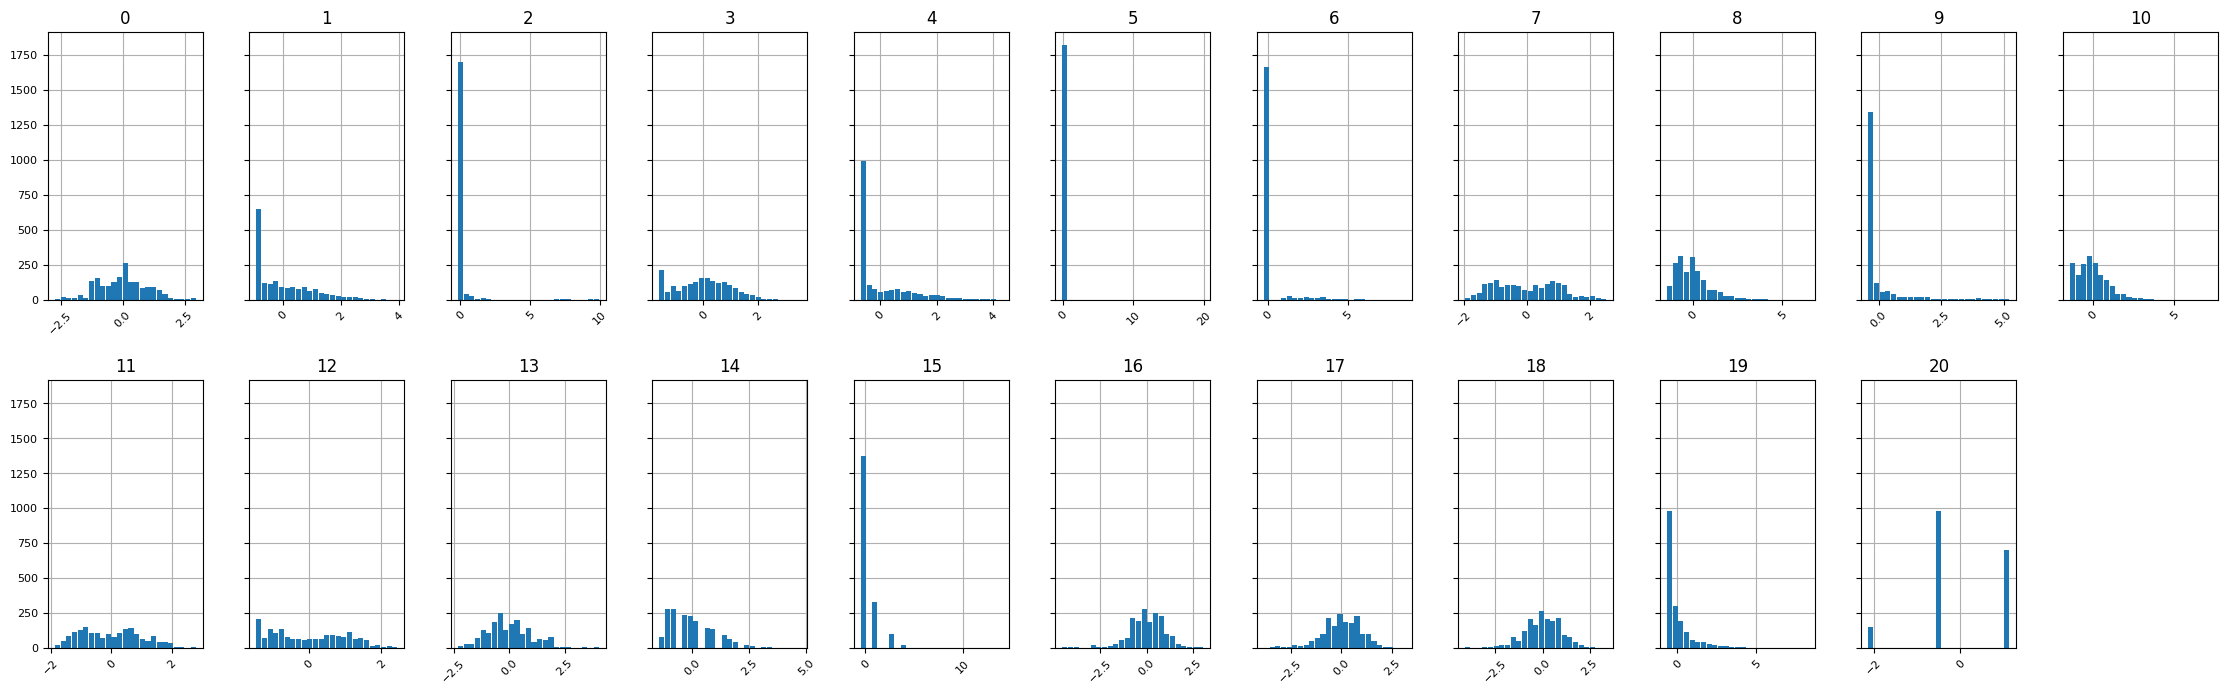

In [ ]:
cardio.x.hist(figsize=(28, 8), bins=25, xlabelsize=8, ylabelsize=8, xrot=45, layout=(2, 11), sharey=True, zorder=2,
              rwidth=0.9)

In [ ]:
cardio.y.describe()

,0
count,1831.000
mean,0.096
std,0.295
min,0.000
25%,0.000
50%,0.000
75%,0.000
max,1.000


In [ ]:
pendigits.y.value_counts()

0    6714
1     156
Name: count, dtype: int64

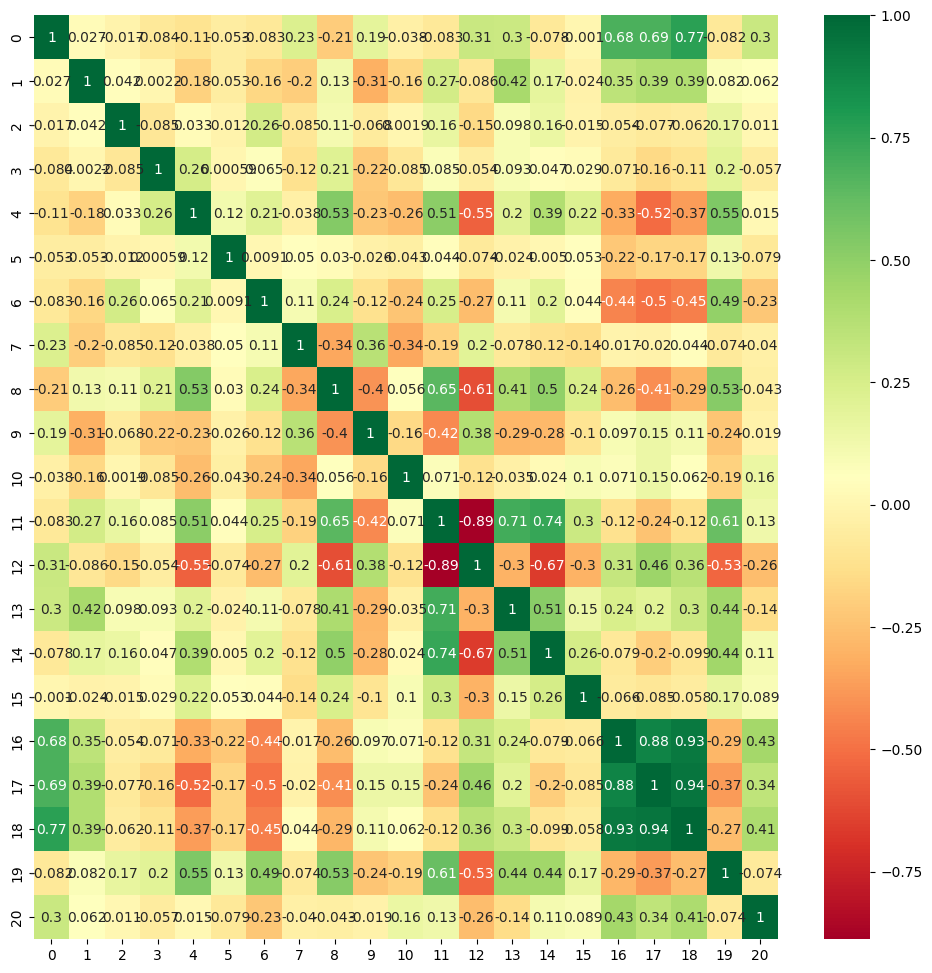

In [ ]:
correlation_map(cardio, figsize=(12, 12))

# Local Outlier Factor

In [503]:
def preprocess_y(y: np.ndarray):
    return np.where(y == 1, 0, 1)

In [508]:
def local_outlier_factor(dataset: Dataset):
    print(f"{' DATASET ' + dataset.name.upper() + ' ':*^100}\n")
    # model = LocalOutlierFactor(n_neighbors=5, novelty=False, contamination='auto')
    model = LocalOutlierFactor(
        n_neighbors=20, algorithm='auto',
        leaf_size=30, metric='minkowski',
        p=2, metric_params=None, contamination='auto'
    )

    dataset.y_pred = DataFrame(preprocess_y(model.fit_predict(dataset.x)))
    dataset.scores_pred = model.negative_outlier_factor_

    accuracy_report(dataset)

In [509]:
for dataset in datasets.datasets.values():
    local_outlier_factor(dataset)

******************************************* DATASET PIMA *******************************************

Number of errors : 273
Accuracy Score : 0.64453125
Classification Report :
               precision    recall  f1-score   support

           0       0.65      0.97      0.78       500
           1       0.38      0.03      0.06       268

    accuracy                           0.64       768
   macro avg       0.52      0.50      0.42       768
weighted avg       0.56      0.64      0.53       768

**************************************** DATASET PENDIGITS *****************************************

Number of errors : 273
Accuracy Score : 0.9656477438136827
Classification Report :
               precision    recall  f1-score   support

           0       0.98      0.99      0.98      6714
           1       0.08      0.05      0.06       156

    accuracy                           0.97      6870
   macro avg       0.53      0.52      0.52      6870
weighted avg       0.96      0.97    

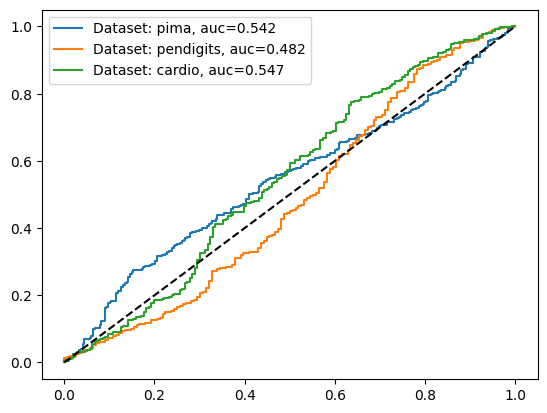

In [510]:
roc_curve_plot(datasets)

# Isolation Forest

In [511]:
def isolation_forest(dataset: Dataset):
    print(f"{' DATASET ' + dataset.name.upper() + ' ':*^100}\n")
    model = IsolationForest(
        n_estimators=200,
        max_samples="auto",
        contamination="auto"
    )
    model.fit(dataset.x)
    dataset.scores_pred = model.decision_function(dataset.x)
    dataset.y_pred = DataFrame(preprocess_y(model.predict(dataset.x)))

    accuracy_report(dataset)

    # conf_matrix(dataset)

    # RocCurveDisplay.from_predictions(
    #     dataset.y,
    #     model.decision_function(dataset.x),
    #     name="Isolation Forest",
    #     color="darkorange",
    #     pos_label=0
    # )
    # plt.plot([0, 1], [0, 1], "k--")
    # plt.axis("square")
    # plt.xlabel("False Positive Rate")
    # plt.ylabel("True Positive Rate")
    # plt.title("Isolation Forest, ROC curve")
    # plt.legend()
    # plt.show()



In [512]:
for name, dataset in datasets.datasets.items():
    isolation_forest(dataset)

******************************************* DATASET PIMA *******************************************

Number of errors : 247
Accuracy Score : 0.6783854166666666
Classification Report :
               precision    recall  f1-score   support

           0       0.69      0.92      0.79       500
           1       0.60      0.24      0.34       268

    accuracy                           0.68       768
   macro avg       0.65      0.58      0.56       768
weighted avg       0.66      0.68      0.63       768

**************************************** DATASET PENDIGITS *****************************************

Number of errors : 247
Accuracy Score : 0.6586608442503639
Classification Report :
               precision    recall  f1-score   support

           0       1.00      0.65      0.79      6714
           1       0.06      1.00      0.12       156

    accuracy                           0.66      6870
   macro avg       0.53      0.83      0.45      6870
weighted avg       0.98      

### ROC curve

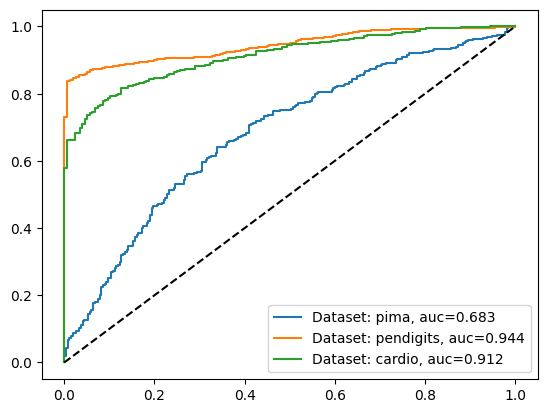

In [513]:
roc_curve_plot(datasets)

In [ ]:

plt.scatter(pima.x[3][:], pima.x[1][:])
plt.show()